In [1]:
from pandas.io.json import json_normalize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm

In [2]:
# Read Json
raw_data = pd.read_json('./realties.json', lines=True)
df = pd.read_json('./realties.json', lines=False)
df_src = json_normalize(data=df['_source'])

del raw_data
del df

In [3]:
## Select columns by follow Data Sprints Doc ##
null_col = df_src.columns[df_src.isna().sum() > 100000]
df_selected = df_src.drop(null_col, axis=1)

del null_col
del df_src

/Users/nuttakanwiriyakrieng/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Value Distribution - Before Cut Outlier')

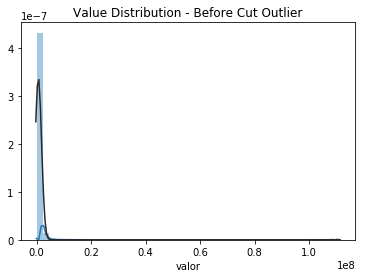

In [4]:
## Plot Value Distribution
sns.distplot(df_selected['valor'].dropna(), fit=norm).set_title("Value Distribution - Before Cut Outlier")

# Wrangling

In [5]:
## Translate Columns Name ##
df_selected.rename(columns={"anunciante.id": "advertiser.id", \
                            "anunciante.nome": "advertiser.name", \
                            "bairro.id": "neighborhood.id", \
                            "bairro.nome": "neighborhood.name", \
                            "banheiro": "bathroom", \
                            "cidade.full_name": "city.full_name", \
                            "cidade.short_name": "city.short_name", \
                            "cidade_uf": "city_uf", \
                            "codigo": "code", \
                            "condominio": "condominium", \
                            "data_inclusao": "date_inclusion", \
                            "descricao": "description", \
                            "endereco": "address", \
                            "tipo_negocio": "business_type", \
                            "garagem": "garage", \
                            "lista_fotos": "photolist", \
                            "opcionais": "optional", \
                            "quarto": "bedroom", \
                            "tipo_imovel": "property_type", \
                            "valor": "value", \
                            "zoneamento.id": "zoning.id", \
                            "zoneamento.nome": "zoning.name", \
                            "zoneamento.sigla": "zoning.initials", \
                            "finalidade": "goal"
                           }, inplace=True)

df_selected['property_type'] = df_selected['property_type'].apply(lambda x: sorted(x)).apply(' ,'.join)

In [6]:
df_selected['property_type'].apply(lambda x: x[0]).unique()

array(['Casa', 'Sobrado', 'Apartamento', 'Quarto', 'Residencia',
       'Terreno', 'Conjunto', 'Garagem', 'Loja', 'Cobertura', 'Duplex',
       'Prédio', 'Galpão', 'Sala', 'Andar', 'Garden', 'Industrial',
       'Loft', 'Pousada', 'Sítio', 'Kitnet', 'Studio', 'Flat', 'Ponto',
       'Sobreloja', 'Triplex', 'Clínica', 'Chácara', 'República',
       'Fazenda', 'Edícula', 'Box', 'Coworking', 'Chalé', 'Resort',
       'Haras', 'Geminado'], dtype=object)

In [89]:
df_selected['property_type'].unique().shape

(673,)

In [72]:
df_selected['property_type'].apply(' ,'.join).unique().shape

(801,)

default
error** -> have some dict
goal** -> name swap place
geometry.coordinates** -> float found
photolist
optional** -> have some dict, use json_normalize to extract
motion_type** -> name swap place

# Duplicate Alert

1. Who duplicate the data?
    A. Popular Advertiser -> advertiser.name?
    B. Third Company -> 
    C. The Company Crawler
2. What do these duplicate ads contain? -> Drop it
3. When are ads duplicated?
4. What happens to duplication, and where(which columns) is in stored?
5. Why are the duplicated?

In [19]:
df_selected['advertiser.name'].unique().shape

(1583,)

In [20]:
df_selected['scraping.spider_name'].unique().shape

(203,)

- Popular Advertiser = advertiser.name
- Third Company = 
- The Company Crawler = scraping.spider_name

### Find Top 20 Advertiser

In [6]:
# df_selected.groupby(['advertiser.name'], as_index=True)['advertiser.name'].count()
top_ads = df_selected['advertiser.name'].value_counts()

[Text(0.5, 0, 'ads count')]

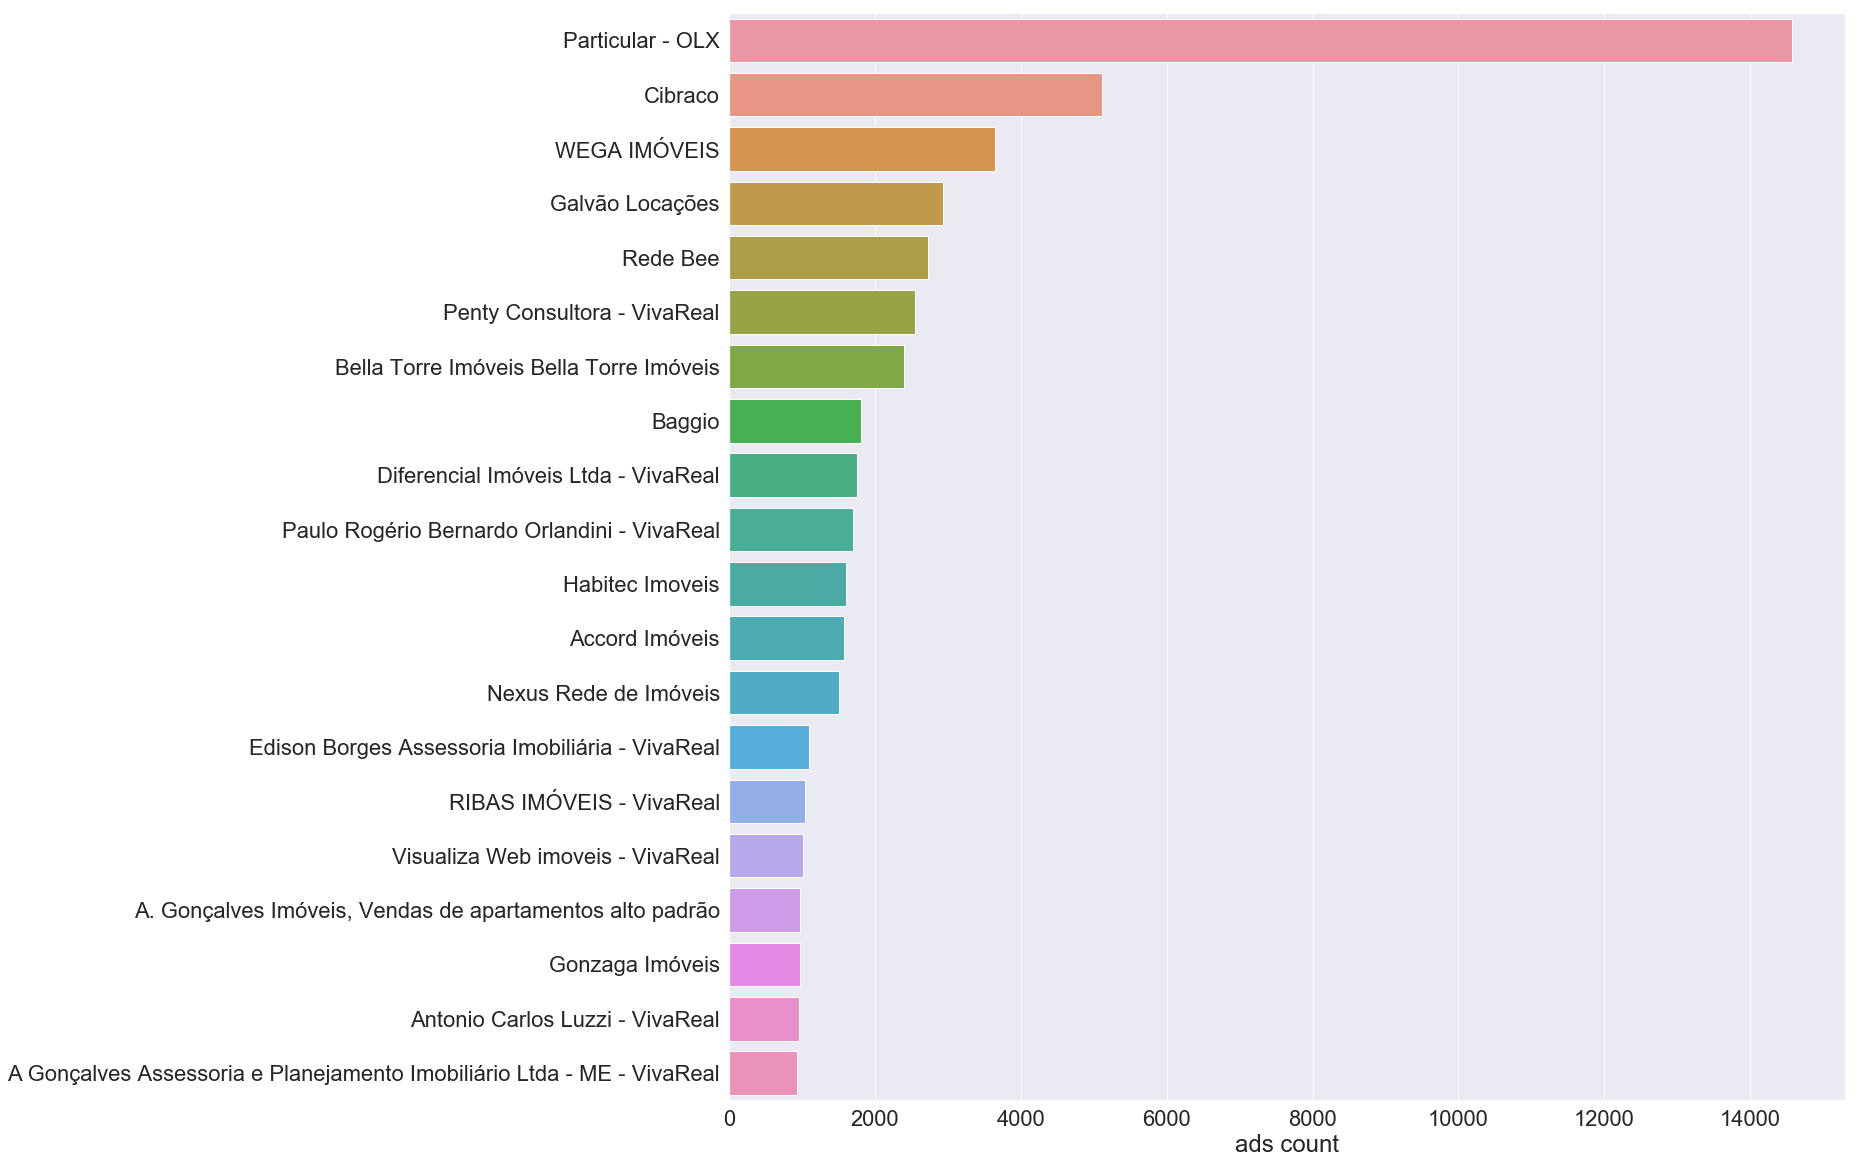

In [7]:
plt.figure(figsize=(20, 20))
sns.set(font_scale=2)
ax = sns.barplot(y=top_ads.index[:20], x=top_ads.head(20))
ax.set(xlabel='ads count')

In [9]:
## Popular Advertiser
top_ads.index[top_ads.values > 50].shape

(475,)

In [10]:
## Third Company
top_ads.index[top_ads.values <= 50].shape

(1107,)

In [11]:
df_selected.isnull().sum()

advertiser.id            1591
advertiser.name          1591
area_total              43776
area_util               28606
neighborhood.id          1148
neighborhood.name        1148
bathroom                38243
city.full_name              0
city.short_name             0
city_uf                     0
code                    84922
condominium             40432
date_inclusion              0
default                     0
description                 0
address                 30348
error                       0
goal                        0
garage                  21169
geohash                 30375
geometry.coordinates    30375
geometry.type           30375
iptu                    53726
isparticular                0
isportal                    0
latitude                30336
photolist                4461
longitude               30336
optional                    0
bedroom                 13090
scraping.spider_name        0
status                      0
suite                   54175
property_t

In [8]:
df_ddp = df_selected.drop_duplicates(['title'], keep='first')

# Deal with value outlier

1. What types of interesting outliers can be identified?
    - What rule should we use to remove or maintain outlier? -> See distibution with z-score

df_ddp['z_value'] = np.abs((df_ddp['value'] - df_ddp['value'].mean())/df_ddp['value'].std(ddof=0))

df_wo = df_ddp[df_ddp['z_value'] < 1]

In [9]:
df_sell = df_ddp[df_ddp['business_type'] == 'Venda']
df_rent = df_ddp[df_ddp['business_type'] == 'Locação']

Text(0.5, 1.0, 'Value Distribution - Rent')

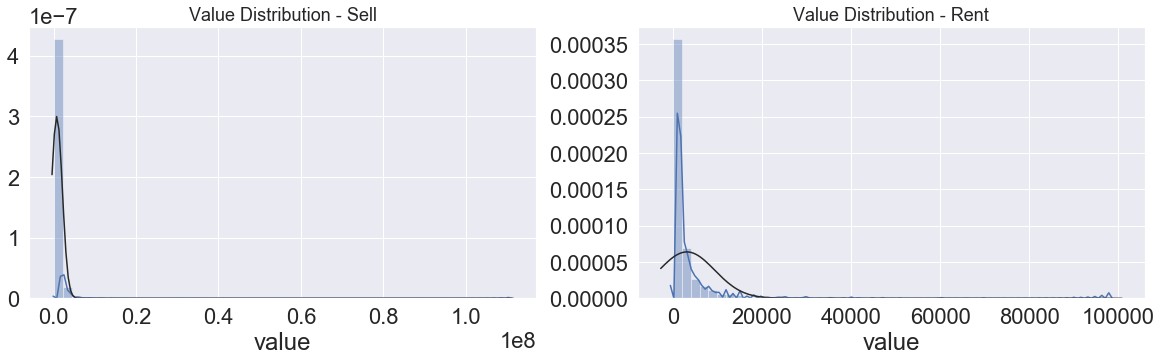

In [10]:
#[df_sell['value']<0.5*1e7]
fig, ax = plt.subplots(1,2, figsize=(20, 5))
sns.set(font_scale=1.5)
sns.distplot(df_sell['value'].dropna(), fit=norm, ax=ax[0]).set_title("Value Distribution - Sell")
sns.distplot(df_rent['value'].dropna(), fit=norm, ax=ax[1]).set_title("Value Distribution - Rent")

In [11]:
df_sell['z_value'] = np.abs((df_sell['value'] - df_sell['value'].mean())/df_sell['value'].std(ddof=0))
df_wo_sell = df_sell[df_sell['z_value'] < 1]

/Users/nuttakanwiriyakrieng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
df_rent['z_value'] = np.abs((df_rent['value'] - df_rent['value'].mean())/df_rent['value'].std(ddof=0))
df_wo_rent = df_rent[df_rent['z_value'] < 1]

/Users/nuttakanwiriyakrieng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Value Distribution - Rent')

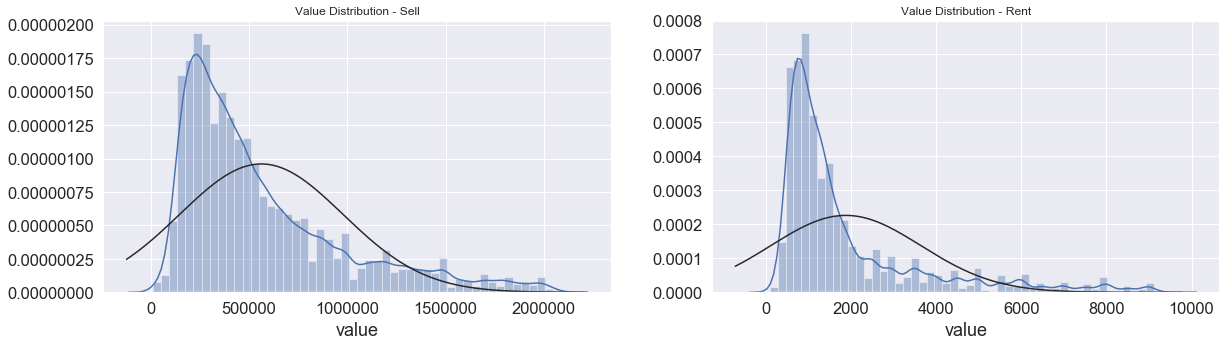

In [13]:
fig, ax = plt.subplots(1,2, figsize=(20, 5))
sns.set(font_scale=1.0)
sns.distplot(df_wo_sell['value'].dropna(), fit=norm, ax=ax[0]).set_title("Value Distribution - Sell")
sns.distplot(df_wo_rent['value'].dropna(), fit=norm, ax=ax[1]).set_title("Value Distribution - Rent")

Text(0.5, 1.0, 'Value Distribution - After Cut Outlier')

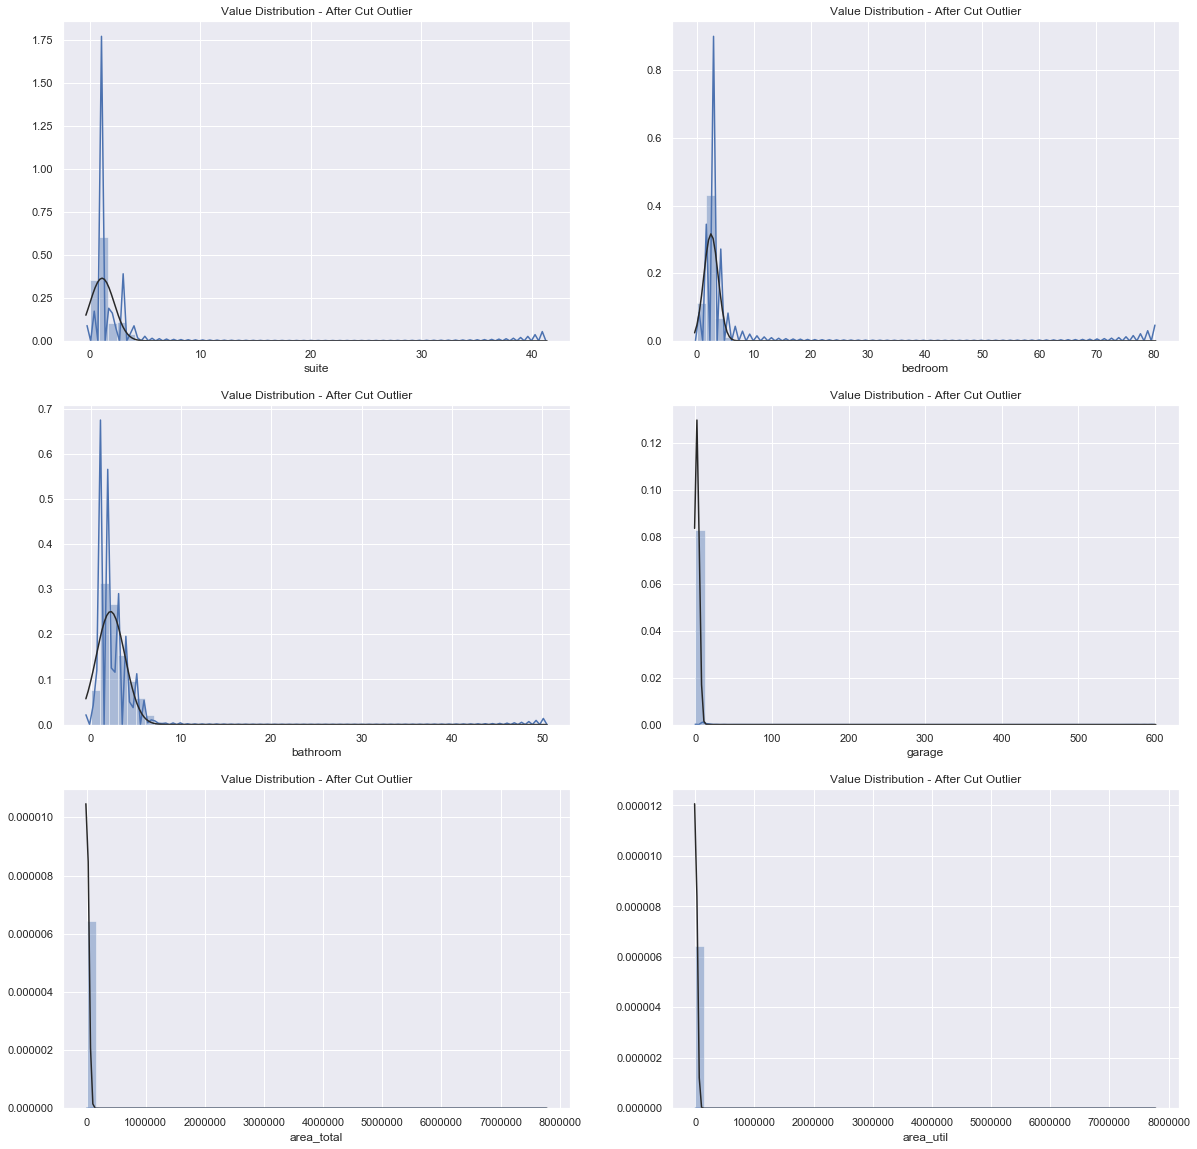

In [14]:
fig, ax = plt.subplots(3,2, figsize=(20, 20))
sns.distplot(df_ddp['suite'].dropna(), fit=norm, ax=ax[0][0]).set_title("Value Distribution - After Cut Outlier") 
sns.distplot(df_ddp['bedroom'].dropna(), fit=norm, ax=ax[0][1]).set_title("Value Distribution - After Cut Outlier")
sns.distplot(df_ddp['bathroom'].dropna(), fit=norm, ax=ax[1][0]).set_title("Value Distribution - After Cut Outlier")
sns.distplot(df_ddp['garage'].dropna(), fit=norm, ax=ax[1][1]).set_title("Value Distribution - After Cut Outlier")
sns.distplot(df_ddp['area_total'].dropna(), fit=norm, ax=ax[2][0]).set_title("Value Distribution - After Cut Outlier")
sns.distplot(df_ddp['area_util'].dropna(), fit=norm, ax=ax[2][1]).set_title("Value Distribution - After Cut Outlier")

# Property Type Analysis

In [15]:
%%time
## Property_type filter 
j = 0
for i in range(df_selected.shape[0]):
    if(len(df_selected['property_type'][i])) > 2:
        j += 1
    else:
        continue
print(j)

4296
CPU times: user 1.96 s, sys: 5.51 ms, total: 1.96 s
Wall time: 1.97 s


In [15]:
df_ddp['main_property_type'] = df_ddp['property_type'].apply(lambda x: [x[0]])

/Users/nuttakanwiriyakrieng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
df_ddp['main_property_type'] = df_ddp['main_property_type'].apply(lambda x: sorted(x)).apply(' ,'.join)

/Users/nuttakanwiriyakrieng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
df_ddp['main_property_type'].value_counts()

Apartamento    37313
Casa           15422
Sobrado         7002
Quarto          6829
Terreno         6206
Sala            2877
Residencia      2804
Cobertura       2459
Loja            1555
Garagem         1362
Studio          1312
Duplex          1175
Conjunto        1032
Garden           932
Prédio           779
Triplex          551
Galpão           541
Andar            503
Sítio            458
Kitnet           342
Industrial       164
Flat             150
Loft             119
Ponto             88
Pousada           56
Edícula           53
Chácara           39
República         35
Box               30
Sobreloja         22
Clínica           14
Geminado          10
Fazenda            5
Coworking          4
Chalé              2
Haras              1
Resort             1
Name: main_property_type, dtype: int64

[Text(0.5, 0, 'ads count')]

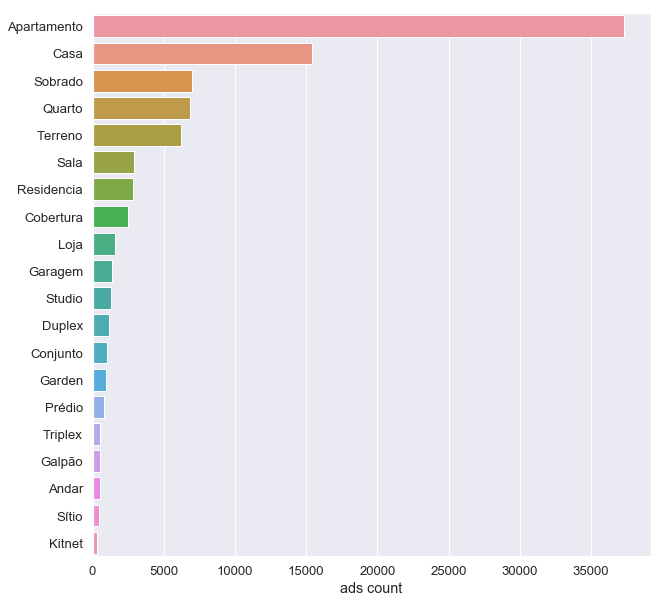

In [18]:
top_prop_type = df_ddp['main_property_type'].value_counts()
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.2)
ax = sns.barplot(y=top_prop_type.index[:20], x=top_prop_type.head(20))
ax.set(xlabel='ads count')

# Explore Geometry

### Cut Outlier Latitude Longitude

In [40]:
df_lat = df_dna_geo['geometry.coordinates'].map(lambda x: x[0])
df_ddp['z_value_lat'] = np.abs((df_lat - df_lat.mean())/df_lat.std(ddof=0))
df_ddp = df_dna_geo[df_dna_geo['z_value_lat'] < 1]

/Users/nuttakanwiriyakrieng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [41]:
df_long = df_dna_geo['geometry.coordinates'].map(lambda x: x[1])
df_ddp['z_value_long'] = np.abs((df_long - df_long.mean())/df_long.std(ddof=0))
df_ddp = df_dna_geo[df_dna_geo['z_value_long'] < 1]

Text(0.5, 1.0, 'Value Distribution - After Cut Outlier')

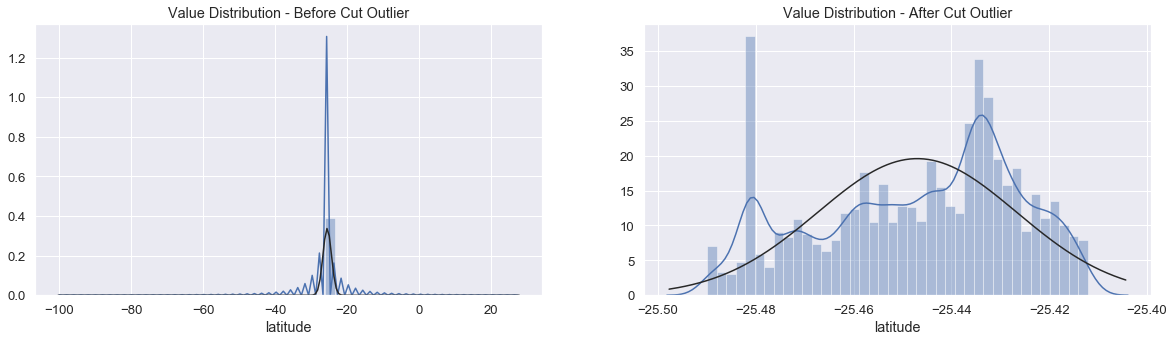

In [151]:
## Plot Value Distribution
fig, ax = plt.subplots(1,2, figsize=(20, 5))
sns.distplot(df_selected['latitude'].dropna(), fit=norm, ax=ax[0]).set_title("Value Distribution - Before Cut Outlier")
sns.distplot(df_dna_geo['latitude'], fit=norm, ax=ax[1]).set_title("Value Distribution - After Cut Outlier")

Text(0.5, 1.0, 'Value Distribution - After Cut Outlier')

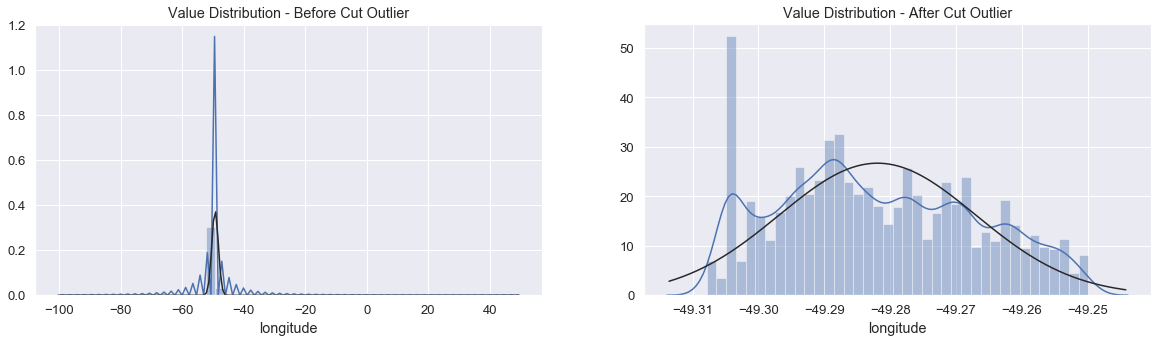

In [152]:
## Plot Value Distribution
fig, ax = plt.subplots(1,2, figsize=(20, 5))
sns.distplot(df_selected['longitude'].dropna(), fit=norm, ax=ax[0]).set_title("Value Distribution - Before Cut Outlier")
sns.distplot(df_dna_geo['longitude'], fit=norm, ax=ax[1]).set_title("Value Distribution - After Cut Outlier")

In [153]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

#### https://geo.nyu.edu/catalog/stanford-vx469jv8459
sf_path = "./geo/Brazil-Curitiba/41MEE250GC_SIR.shp"
sf = gpd.read_file(sf_path, encoding='utf-8')
curi_sf = sf[sf.NM_MESO == 'METROPOLITANA DE CURITIBA']
curi_shape = curi_sf.to_crs({'init':'epsg:4326'})

#### https://download.geofabrik.de/south-america/brazil.html
roads_path = './geo/Brazil-Curitiba-Road/gis_osm_roads_free_1.shp'
road = gpd.read_file(roads_path, encoding='utf-8')

### Don't Forget to talk about encoding 'utf-8'

In [138]:
# http://ippuc.org.br/geodownloads/geo.htm
nbh_border_path = './geo/realties/DIVISA_DE_BAIRROS.shp'
nbh_border = gpd.read_file(nbh_border_path)
nbh_border_shape = nbh_border.to_crs({'init':'epsg:4326'})

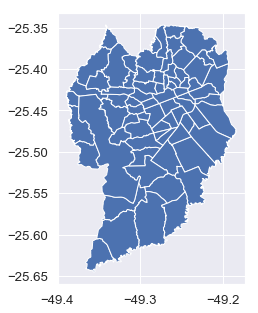

In [140]:
nbh_border_shape.plot(figsize=(5, 5))

### Convert Geo to work with Geopandas

In [44]:
df_dna_geo = df_ddp.dropna(subset=['geometry.coordinates'], axis=0)

In [45]:
geometry = [Point(xy) for xy in zip(df_dna_geo['geometry.coordinates'].map(lambda x: x[0]), df_dna_geo['geometry.coordinates'].map(lambda x: x[1]))]

In [46]:
df_dna_geo = gpd.GeoDataFrame(df_dna_geo, crs={'init':'epsg:4326'}, geometry=geometry)

Text(0.5, 1.0, 'Ads Map')

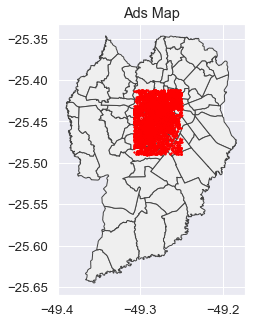

In [141]:
ax = zone_shape.plot(figsize=(5, 5), color='#EFEFEF', edgecolor='#444444')
df_dna_geo.plot(ax=ax, color='red', markersize=1)
plt.title('Ads Map')

In [157]:
union_nbh = gpd.sjoin(nbh_border_shape, df_dna_geo, op='intersects')
union_nbh.plot()

Text(0.5, 1.0, 'Ads Map')

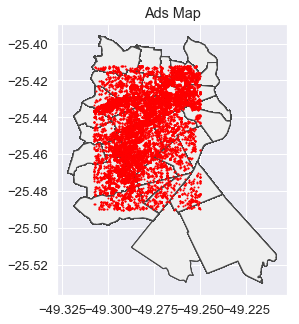

In [145]:
ax = union1.plot(figsize=(5, 5), color='#EFEFEF', edgecolor='#444444')
df_dna_geo.plot(ax=ax, color='red', markersize=1)
plt.title('Ads Map')

In [154]:
# http://ippuc.org.br/geodownloads/geo.htm
zone_path = './geo/Brazil-Curitiba-Zone-SAD69_CWB/ZONEAMENTO.shp'
zone = gpd.read_file(zone_path2)
zone_shape = zone2.to_crs({'init':'epsg:4326'})

In [130]:
df_ddp['zoning.initials'].unique()

array(['SE', 'ZR-4', 'ZC', 'ZR-B', 'ZR-3', 'SE-CC', 'SH', nan, 'ZR-1',
       'ZR-M', 'CONEC-4', 'ZT-LV', 'PÓLO-LV', 'SE-MF', 'CONEC-3', 'SE-WB',
       'ZT-MF', 'ZR-SF', 'SE-LV', 'UC', 'ZE-D', 'ZR-2'], dtype=object)

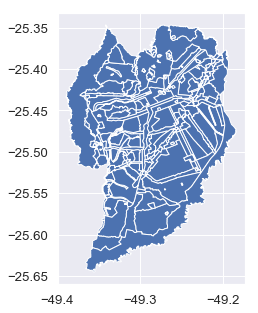

In [156]:
zone_shape.plot(figsize=(5, 5))

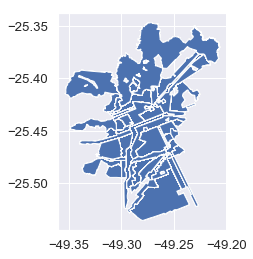

In [162]:
union_zone = gpd.sjoin(zone_shape, df_dna_geo, op='intersects')
union_zone.plot()

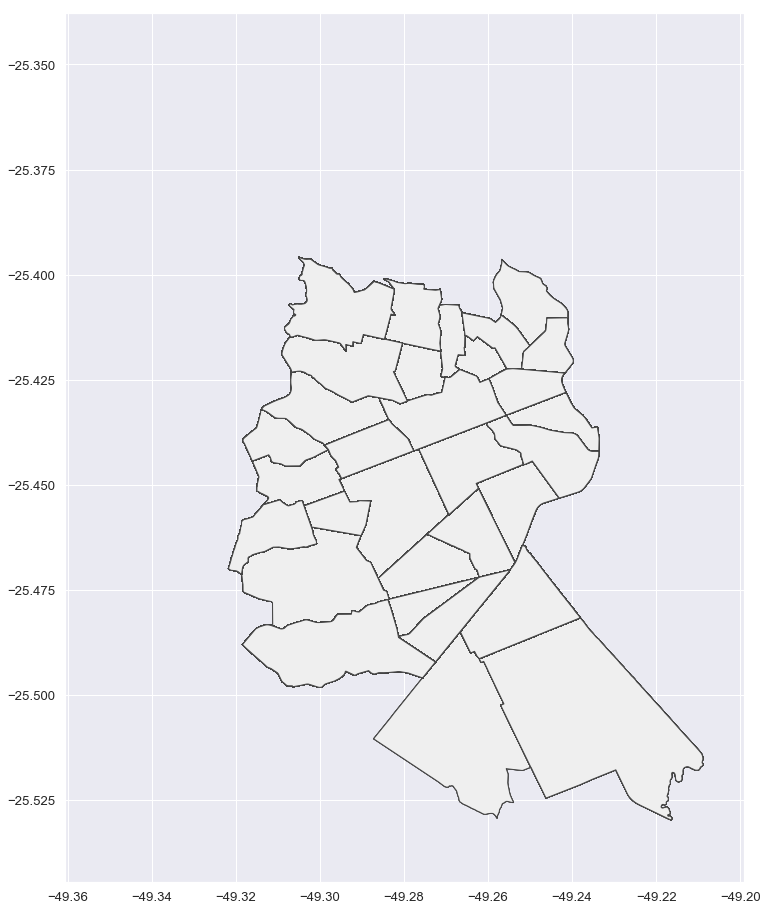

In [168]:
ax = union_nbh.plot(figsize=(18,16), color='#EFEFEF', edgecolor='#444444')
union_zone.plot(ax=ax, color='green', alpha=0.0)

# Value Analysis

### Beware! Business Type

## Top 20 High price neighborhood

In [ ]:
top_mean_price = df_wo[['neighborhood.name', 'value']].groupby(['neighborhood.name'], as_index=False).mean()

In [ ]:
top_mean_price.sort_values(by=('value'), ascending=False).head(20)

top_mean_price.sort_values(by=('value'), ascending=False).head(20)

In [ ]:
plt.figure(figsize=(10, 10))
ax = sns.barplot(x="value", y="neighborhood.name", data=top_mean_price.sort_values(by=('value'), ascending=False).head(20))

## Map of the Top 20 High Price neighborhood

## Distribution Top 10 price neighborhood

In [ ]:
## top price neighborhood name ##
top_10_name = top_mean_price.sort_values(by=('value'), ascending=False).head(10)['neighborhood.name'].unique()

In [ ]:
list(top_10_name)

In [ ]:
df_top10_dist = df_wo[df_wo['neighborhood.name'].isin(top_10_name)]

In [ ]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=df_top10_dist, x="value", y="neighborhood.name")

## Bedrooms and Price Analysis

### Cleaning Bedrooms

In [ ]:
df_wo[['bedroom']]

In [ ]:
bedroom_price = df_wo[['bedroom', 'value']].groupby(['bedroom'], as_index=False).mean()
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="bedroom", y="value", data=bedroom_price.sort_values(by=('value'), ascending=False).head(30))

In [ ]:
## Notes ##
# have outlier in bedrooms

## Garage and Price Analysis

In [ ]:
garage_price = df_wo[['garage', 'value']].groupby(['garage'], as_index=False).mean()
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="garage", y="value", data=garage_price.sort_values(by=('value'), ascending=False).head(30))

## Bathroom and Price Analysis

In [ ]:
bathroom_price = df_wo[['bathroom', 'value']].groupby(['bathroom'], as_index=False).mean()
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="bathroom", y="value", data=bathroom_price.sort_values(by=('value'), ascending=False).head(30))

## Suite and Price Analysis

In [ ]:
suite_price = df_wo[['suite', 'value']].groupby(['suite'], as_index=False).mean()
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="suite", y="value", data=suite_price.sort_values(by=('value'), ascending=False).head(30))

## Area and Price Analysis

In [ ]:
area_total_price = df_wo[['area_total', 'value']].groupby(['area_total'], as_index=False).mean()
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="area_total", y="value", data=area_total_price.sort_values(by=('value'), ascending=False).head(20))

### Number
area_total -
area_util -
bathroom -
garage -
bedroom -
suite

In [ ]:
df_est_prop = df_wo[['value','area_total', 'area_util', 'bathroom', 'garage', 'bedroom', 'suite']]

In [ ]:
df_est_prop_corr = df_est_prop.corr()

In [ ]:
plt.figure(figsize=(10, 10))
pp = sns.heatmap(df_est_prop_corr, linewidths=.2, cmap="YlGnBu", annot = True)